# Customizing rendering in SolveIt

_author: algal0 (Discord), alexisgallagher (X)_

This dialog teaches how to customize the rendering of content in SolveIt -- web content, objects, data, etc..

This sort of customization is powerful. It lets you make SolveIt into an environment for your data, for your problem. And it requires "just" a few lines of code.

But it can also be a little obscure since it requires functions defined in external libraries, as well as background knowledge of web tech, of notebook environments, and of undocumented aspects of SolveIt's internals. So I thought I'd put all the pieces together right here, and show both how to do it and also why it works.

We'll start by reviewing the function `show` and then move on to `display`, which is more powerful and the basis of SolveIt's own rendering.

## Introducing `show`

### Inserting web content, with `show`

In Solveit, the function `fasthtml.common.show` will simply insert HTML web content directly into the web content of the dialog itself.

You can pass `show` a Python `str` of the raw web content. 

In [ ]:
from fasthtml.common import show
from fasthtml.common import Strong

In [ ]:
show('<strong>I am strong text</strong>')

You can also pass the function a FastHTML tag (an FT) tag, which is mostly a syntactic sugar around HTML.

In [ ]:
show(Strong("I am strong text"))

You can see it is directly inserted by opening the web inspector (CMD-OPTION-I on Mac) and examining the output cell. There is the HTML.


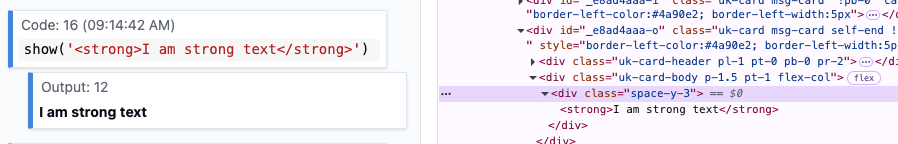


### Calling `show` repeatedly

When you `show` an object, you are doing something different from what happens normally when you see the output of evaluated code.

Normally, you only see the last value of the cell, and you will see something for pretty much any kind of object.

For instance, this cell defines two values which are both evaluated, but we only see the second value in code output. We see this value, which is an `int`, without problems.

In [ ]:
a = 41
a  # I'm the first value, I'm right here!
b = 42
b # I'm the second value

42

In contrast, `show` can be called multiple times and it will insert web content into the output cell multiple times:

In [ ]:
from fasthtml.common import Strong,P

show(P(Strong("I am the first strong text")))

show(P(Strong("I am the second strong text")))

And, `show` will fail if you pass it an arbitrary object, like an `int`:

In [ ]:
show(42)


TypeError: 'int' object is not subscriptable

So `show` is different from the normal, automatic rendering of code outputs. I will explain this in the later section on `display`. But for now, let us focus on some immediately useful tips.

### Protecting web content, with `Iframe`

The inserted web content is _unprotected_ from all the surrounding web content in the dialog itself, which defines a SolveIt dialog page and its style rules. So those rules will affect layout, typography, and color of your content. 

We could try to protect the web content by adding more CSS to counter-act the surrounding environment. But this is tricky and unreliable, since it requires knowing all the effects you want to cancel. 

AFAICT, the only simple and reliable way to protect web content is to wrap it in an Iframe.  This is what  `show(iframe=True)` does:

In [ ]:
show(Strong("I am strong text"),iframe=True)

We can see that this content is now _protected from the dialog_ from the fact that the font is now different, and uglier. It has been protected from style rules which define the font used for text in the dialog itself.

We can also see it directly by examining the Web Inspector. It shows our `<strong>` element right now, and also that some boilerplate was inserted for us, in `<html>`, `<head>`, and `<body>` elements. All of it is within an `<iframe>` element.


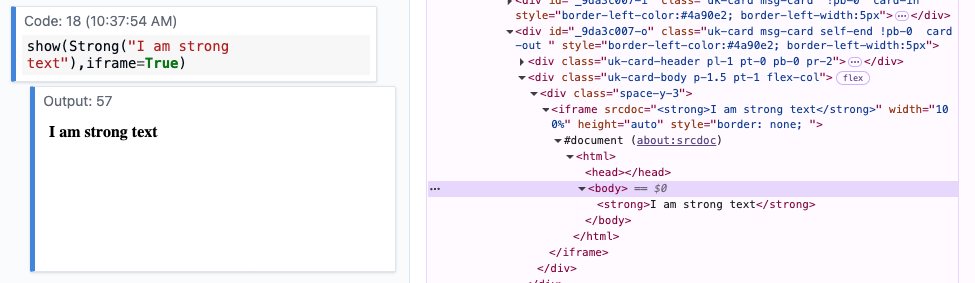


But what if we want our own boilerplate? Enter qshow.

### Defining a helper, `qshow`

You might often see someone define a function `qshow`. This is just a common idiom if you expect to be using show a lot, to define your own version of show for your purposes in a particular dialog.

For instance, we could define a `qshow` which always uses an iframe and applies Sakura, a popular CSS reset.

In [ ]:
from fasthtml.common import Html, Head, Body, Link

sakura_headers = [Link(href='https://cdn.jsdelivr.net/npm/sakura.css/css/sakura.css', rel='stylesheet', type='text/css')]
     
def qshow(*c, height='auto'):
    doc = Html(Head(*sakura_headers), Body(*c))
    show(doc, iframe=True, height=height)

In [ ]:
qshow(Strong("I am strong text"))

This example also shows that we can pass to `show` not just an HTML fragment like `<strong>Hello</strong>` (aka, an HTML _partial_) but also an entire HTML document, starting with the `<html>` element itself and including a `<head>` element, etc. 


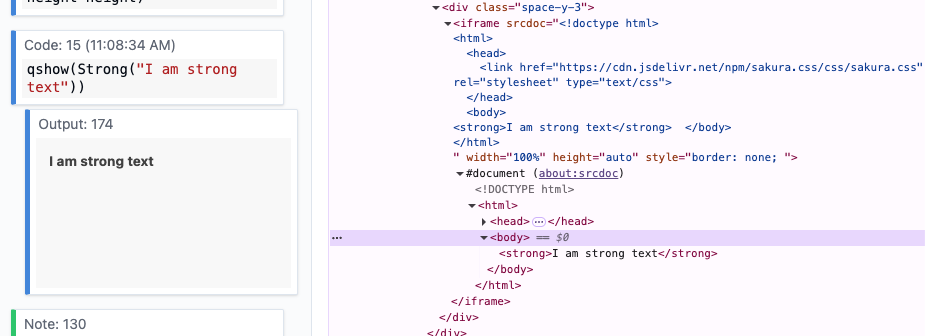


### Defining a custom FT representation for `show`

Let us say we want to `show` our own object, rather than an FT object.

Then what? Then we need **a way to tell our object how to represent itself as FT tags**. This is done with `__ft__(self)`.

We can see this clearly with a custom type. `show` chokes if its argument does not have `__ft__`, and works if it does.

In [ ]:
class User:
    def __init__(self,name:str,city:str):
        self.name=name
        self.city=city


In [ ]:
u = User('Alexis','SF')

In [ ]:
# I will fail, because `User` does not define `__ft__`
show(u)

TypeError: 'User' object is not subscriptable

Now we add `__ft__`

In [ ]:
from fasthtml.common import Div,P

class User:
    def __init__(self,name:str,city:str):
        self.name=name
        self.city=city
    def __ft__(self):
        return Div(P(f"name: {self.name}"),P(f"city: {self.city}"))

In [ ]:
u = User('Alexis','SF')

In [ ]:
show(u)

### FT rendering

If you do not `show` an FT element, then by default Solveit will render it by showing the corresponding HTML 

In [ ]:
ft_tags = P(Strong("hello"))
ft_tags

```html
<p>
<strong>hello</strong></p>

```

But if you want to, you can call `fasthtml.jupyter.render_ft()` once, and that will update the FT class so that all FT elements are automatically shown -- that is, rendered as HTML into the dialog.

In [ ]:
# import fasthtml
# fasthtml.jupyter.render_ft()


I will say more about how and why this works later.

### TLDR on show

To recap:

- `fasthtml.common.show` will insert html or FT tags directly into the cell output.
- You can call it multiple times and it will insert multiple times into the output area. It does not return a value.
- Use `show(iframe=True)` if you want to protect your content from the dialog style environment. This is necessary for accurate previews if you are developing web content.
- When using an iframe, pass in an html element or FT tag, if you want to include `<head>` material like CSS stylesheets and JS
- You can make any object `show`able by defining an `__ft__` function.
- You can modify your session so all FT objects render in the dialog automically, by calling `fasthtml.jupyter.render_ft`

## Introducing `display`

### Inserting object content, with `display`

But what if you want to render your object as HTML directly, rather than as FT objects?

Or what if you want ultimately to render your object in HTML (so you can see it in SolveIt) but you would prefer to describe the rendering in a convenient intermediate format, like Markdown or LaTeX?

In such cases, you need to understand `display`. 

The function `show`, and the FT representation function `__ft__` which it looks for, both come from FastHTML. They are a simpler version of the `display` machinery, which they use, and which underlies rendering in SolveIt and in many other system.

Here's how it works:

`show` does the following:
- it takes an object
- it looks for `__ft__()`, with that generates FT tags,
- it converts those to HTML,
- it inserts that web content into the the dialog itself, rendering it

`display` does the following:
- it takes a object.
- it checks for various _representation functions_ -- `__repr__`, `_repr_html_`, `_repr_markdown_`, `_repr_latex_`, etc..
- it talks to the SolveIt frontend to determine the preferred representation from the available set.
- SolveIt itself then converts that preferred representation into HTML, i.e., web content
- SolveIt inserts that web content into the dialog itself, rendering it.


The first thing to note is that one of the repr functions which display looks for is `__repr__`, which every Python object gets by default. So although you cannot `show(42)` since 42 is an `int` and there is not `__ft__` method on that type, you can `display(42)` with no issue

In [ ]:
import IPython
IPython.display.display(42)

42

This works because `display` is inserting the content directly, not because it is simply returning 42 and relying on the normal automatic rendering of output. We can confirm this by printing the return value explicitly

In [ ]:
import IPython
retval = IPython.display.display(42)
print(retval)


42

None


### dialogs already use `display`!

Because `display` uses the default object `__repr__`, it shows us a familiar representation for any object which lacks explicit customization of its repr.

In [ ]:
class Foo:
    def __init__(self):
        pass


In [ ]:
IPython.display.display(Foo())

Why does this look so familiar? Because `display` is in fact what is driving the default rendering of the final value of a code output cell!

In [ ]:
Foo()

In other words, you have been `display`ing all along, without even realizing it. The power was always within you...

### Inserting any content with `display`

Recall that the `display` system allows objects to offer _multiple_ representations, and allows SolveIt to choose its preferred representation.

Let's see this in action. We'll define a type with multiple represenations, we'll see which ones SolveIt prefers, and we'll examine them explicitly to consolidate our understanding of what is going on.

In [ ]:
class MyNum:
    def __init__(self,n): self.n=n
    def _repr_html_(self):     return f"html: <strong>{self.n}</strong>"
    def _repr_markdown_(self): return f"markdown: **{self.n}**"
    def _repr_latex_(self):    return "\text{latex: }" + f"\({self.n}\)"
    def __repr__(self):        return f"repr {self.n}"


In [ ]:
MyNum(42)

repr 42

So we see HTML beats markdown, latex, or the native Python object repr. Let's remove HTML and see what comes next:

In [ ]:
class MyNum:
    def __init__(self,n): self.n=n
    def _repr_markdown_(self): return f"markdown: **{self.n}**"
    def _repr_latex_(self):    return "\text{latex: }" + f"\({self.n}\)"
    def __repr__(self):        return f"repr {self.n}"


In [ ]:
MyNum(42)

markdown: **42**

But notice what is happening here: when the markdown representation is used, it is still displayed in the dialog as HTML:


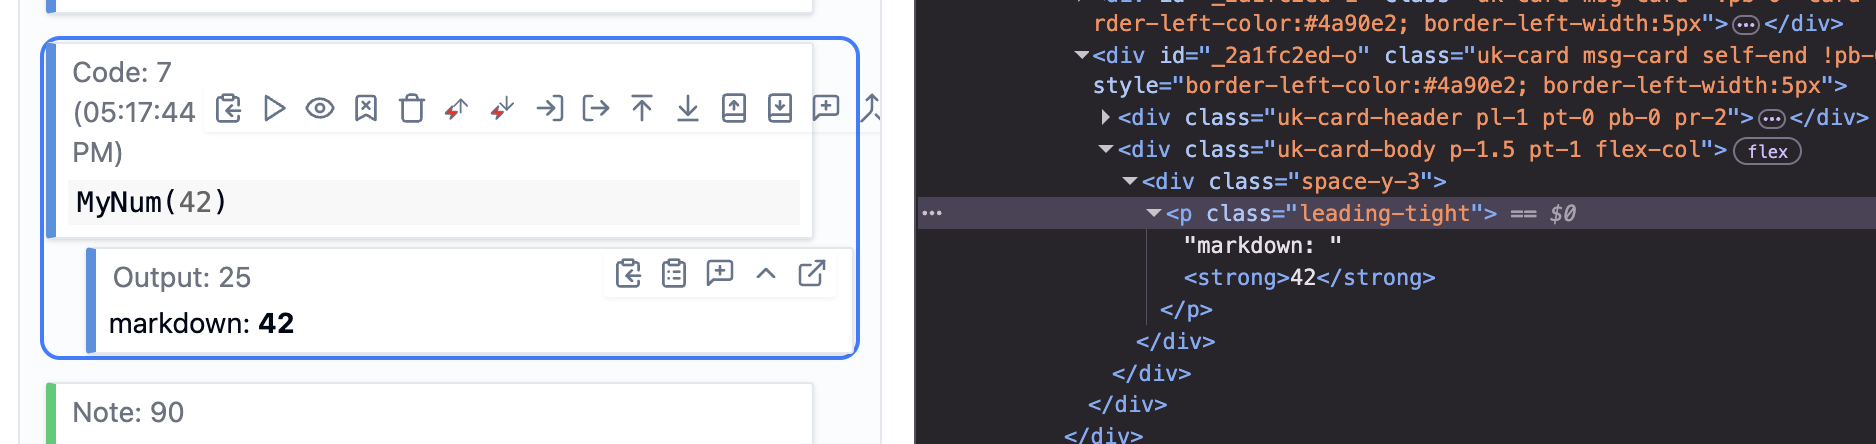


All of this illustrates a few points. The `_repr_markdown_` function lets the object say _that_ it can represent itself as markdown, and _how_ it represents itself as markdown.

But it's the SolveIt frontend which decides _whether_ to use that representation -- for instance, deciding _not_ to use it when an html representation is available, and deciding to use it instead of a latex representation.

Finally, since Solveit ultimately renders to HTML, it's the Solveit frontend which converts that markdown into HTML and decides how to do that.

We could infer SolveIt's preference order by continuing to experiment with it as shown above, but I will spare you the suspense, the SolveIt preference order is: html > markdown > latex > native repr. It also supports various image and media types as well.

We can even directly inspect the representations which are made available to SolveIt. They are described as mimetypes:

In [ ]:
from IPython.core.formatters import format_display_data

obj = MyNum(42)
data, metadata = format_display_data(obj)
data

{'text/plain': 'repr 42',
 'text/html': 'html: <strong>42</strong>',
 'text/markdown': 'markdown: **42**',
 'text/latex': '\text{latex: }\\(42\\)'}

### Forcing a representation

Suppose you have an obejct like a str and you want to see how it renders with one particular representation?

Instead of defining a custom class like we did above, you could just call a function which wraps your object with a new object which provides the desired representation. In fact, this is what functions like `IPython.display.HTML` and `IPython.display.Latex` do. 

In [ ]:
IPython.display.HTML("<strong>Hello</strong>")

In [ ]:
IPython.display.Latex('x^2')

<IPython.core.display.Latex object>

In fact, this is how `show` is implemented. If you look past the details, in essence, it generates a string of HTML with `to_xml`, calls `IPython.display.HTML` to generate an object wrapping it with the desired repr, and then calls `IPython.display.display()` to insert it into the dialog.

In [ ]:
show??


```python
def show(ft, *rest, iframe=False, height='auto', style=None):
    "Renders FT Components into HTML within a Jupyter notebook."
    if isinstance(ft, str): ft = Safe(ft)
    if rest: ft = (ft,)+rest
    res = to_xml(ft)
    if iframe:
        style = "border: none; " + (style or "")
        cfg = dict(frameborder=0, width='100%', height=height, style=style)
        res = to_xml(Iframe(srcdoc=res, **cfg))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        display.display(display.HTML(res))
```

**File:** `~/aai-ws/fasthtml/fasthtml/components.py`

We can see that `IPython.display.HTML` is returning an object, rather than displaying directly, by capturing the return value, examining it, and seeing the repr functions right there:

In [ ]:
retval = IPython.display.Latex("E = m c ^2")
[f for f in dir(retval) if 'repr' in f]

['__repr__', '_repr_latex_']

### calling `display` repeatedly

Now that we know that `show` merely called `display`, it is no surprise we can also repeatedly call `display`

In [ ]:
for i in range(5):
    IPython.display.display(i)

0

1

2

3

4

### FT and render_ft, revisited in light of display 

By default, FT tags render as syntax-highlighted HTML:

In [ ]:
ft_tags = P(Strong("hello"))
ft_tags

```html
<p>
<strong>hello</strong></p>

```

Now we have the tools to see why...

In [ ]:
[f for f in dir(ft_tags) if 'repr' in f]

['__repr__', '_repr_markdown_']

In [ ]:
ft_tags._repr_markdown_??


```python
def highlight(s, lang='html'):
    "Markdown to syntax-highlight `s` in language `lang`"
    return f'```{lang}\n{to_xml(s)}\n```'
```

**File:** `~/aai-ws/fastcore/fastcore/xml.py`

It seems to be: because they render themselves as a markdown code fence of their content.

If we want to render rather than just read their HTML, we know we can use `show`.

But if we want the dialog always to render FT tags, then we can call `render_ft()` to cause automatic rendering for the rest of the session lifetime.

In [ ]:
import fasthtml
from fasthtml.jupyter import render_ft

In [ ]:
render_ft??


```python
def render_ft(**kw):
    "Call once in a notebook or solveit dialog to auto-render components"
    @patch
    def _repr_markdown_(self:FT):
        scr_proc = Script('if (window.htmx) htmx.process(document.body)')
        return to_xml(Div(self, scr_proc, **kw))
```

**File:** `~/aai-ws/fasthtml/fasthtml/jupyter.py`

Now we can also see how `render_ft` works: it modifies the `FT` type to add a markdown representation for all FT objects, where they render themselves not as code fences of their HTML but as the HTML itself. This works because SolveIt's own Markdown render accepts that inline HTML.

### TLDR on display:

- `IPython.display.display()` inserts any Python object directly into the cell output. (like `show`)
- `display()` can be called repeatedly and returns no value. (like `show`)
- `display()` is in fact what is used to render value of every code evaluation!
- How `display()` renders an object depends on a multi-stage negotiation:
   - The object defines the normal Python `__repr__`, and possibly various `_repr_TYPE_` functions.
   - SolveIt picks which representation to use (e.g., preferring html > markdown > latex > repr).
   - SolveIt then converts markdown into html, and maybe LaTeX depending on if USE_KATEX=1
   - html is then inserted into the dialog.

This machinery is similar to many other environments and derives from `IPython`.


## Key takeaways:

- Use `fasthtml.common.show` to render html strings or FT tags.
- If you want to control rendering precisely, protect it with an iframe.
- The lower level machinery is `IPython.display.display`, which is what `show` and SolveIt itself uses.
- If you want to define automatic rendering, use repr functions like `_repr_TYPE_` which display detects.
  - for a convenient repr, use `_repr_markdown_`.
  - for precise control, use `_repr_html_` and probably also use an iframe for protection


# Scratch